# Time Series Seasonal Analysis
Using historical data is a crucial component in predicting the future. This chapter is going to be focusing on how historical trends can be used to forecast future data while creating an indepth understanding of the parameters at play.

## Monthly Car Sales
Looking at monthly car sales is going to be the key component of this chapter as this data is going to be used to forecast future sales.

### Setting up Jupyter Notebook

#### Import Packages

In [1]:
#Import necessary packages and set options for jupyter notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### Loading Functions

#### Data Plotting

In [2]:
#Create a function for line time series
def line_series(x,y,title,xlabel,ylabel):
    plt.figure(figsize=(12,8))
    plt.plot(x,y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [3]:
#Create a function that plots multiple lines
def plot_multiple_series(xvalue,yvalues,labels,title,xlabel,ylabel):
    plt.figure(figsize=(14,8))
    for i in range(len(labels)):
        plt.plot(xvalue, yvalues[i], label=labels[i])
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
#Create a function that plots multiple lines
def plot_multiple_series_xvalues(xvalues,yvalues,labels,title,xlabel,ylabel):
    plt.figure(figsize=(14,8))
    for i in range(len(labels)):
        plt.plot(xvalues[i], yvalues[i], label=labels[i])
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
#Create a function for rolling average values
def rolling_average(x,y,title,xlabel,ylabel,window):
    plt.figure(figsize=(12,8))
    rolmean = y.rolling(window).mean()
    plt.plot(x,y)
    plt.plot(x,rolmean,linestyle='-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [6]:
#Create a function for a least squares line

#Import the neccessary packages
from sklearn.linear_model import LinearRegression

def least_squares_line(incrementing_value,y_value,title,xlabel,ylabel):
    plt.figure(figsize=(12,8))

    #Create the x and y values for the least squares lines
    x_trend_least_squares = incrementing_value.values.reshape(-1,1).astype(float)
    y_trend_least_squares = y_value.astype(float) 

    #Train the model using linear regression packagage
    model = LinearRegression()

    #Fit the model to the x and y values
    model.fit(x_trend_least_squares,y_trend_least_squares)

    #Create the y values for the least squares
    y_pred = model.predict(x_trend_least_squares)

    plt.plot(x_trend_least_squares, y_trend_least_squares, label='original data', color='blue')
    plt.plot(x_trend_least_squares, y_pred, label='least squares', color='red')

    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

    #Get the slope (coefficient) and intercept
    slope = model.coef_[0]
    intercept = model.intercept_

    return slope, intercept

In [7]:
#Include parallel lines which suggest when covid-19 and the global financial crises took place
#Creating a deeper understanding of their direct impact
def plot_with_annotated_dates(xvalues, yvalues, events_list, date_of_events_list, xlabel, ylabel, title):
    plt.figure(figsize=(10, 6))
    plt.plot(xvalues, yvalues, label='Monthly Cars Sold')
    
    # Convert date_of_events_list to datetime
    date_of_events_list = pd.to_datetime(date_of_events_list)
    
    for event, date in zip(events_list, date_of_events_list):
        plt.axvline(x=date, color='orange', linestyle='--', label=event)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
#Create a function that focuses on a specific time period
#This can help create a deeper understanding of how data values change on a regular pattern
def data_period(df,x,y,time_period1,time_period2): 
    index_1 = df[x == time_period1].index[0]
    index_2 = df[x == time_period2].index[0]
    y_time_period = y.iloc[index_1:index_2]
    return y_time_period

#### Seasonal Decomposition

In [9]:
def additive_seasonal_decomposition(data, period):
    
    decomposition = seasonal_decompose(data, model='additive', period=period)

    # Decomposed components
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    return trend, seasonal, residual


In [10]:
def plot_additive_seasonal_decomposition(data, period):

    decomposition = seasonal_decompose(data, model='additive', period=period)

    # Decomposed components
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Create subplots
    plt.figure(figsize=(10, 8))

    # Plot the original data
    plt.subplot(411)
    plt.plot(data, label='Original')
    plt.legend()

    # Plot the trend
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend()

    # Plot the seasonal
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonal')
    plt.legend()

    # Plot the residual
    plt.subplot(414)
    plt.plot(residual, label='Residual')
    plt.legend()

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

#### Data Conversion

In [11]:
#When dealing with monthly values it can be useful to split it up into months of the year with days within them
def create_monthly_data(df,value_column,incrementing_month):

    #Create list of months
    months = ['January','February','March','April','May','June','July','August','September','October','November','December']

    original_copy = df.copy()
    original_copy['Incrementing Month'] = range(0,len(original_copy))
    original_copy.set_index(incrementing_month,inplace=True)

    #Determine the number of years
    num_years = (len(df)+11) // 12

    #Create a new dataframe where the index is the number of years and the columns are the number of months
    monthly_data = pd.DataFrame(index=range(num_years),columns = months)

    #Fill the empty dataframe
    for i, row in original_copy.iterrows():
        year = (i-1) // 12
        month = months[(i-1) % 12]
        monthly_data.at[year,month] = row[value_column]

    return monthly_data

In [12]:
def create_zscores(data,z_threshold,meanvalues):
    data_new = data.copy()
    for col_name in data.columns:
        mean = data[col_name].mean()
        std = data[col_name].std()
        data_new[col_name] = (data[col_name] - mean) / std

        # Identify anomalies
    anomalies_boolean = abs(data_new) > z_threshold

    for id,column in enumerate(anomalies_boolean.columns):
        # For each True value in df_bool column, update the corresponding value in df_data
        data.loc[anomalies_boolean[column], column] = meanvalues[id]

    #think about how to replace something of the same index for row and column from one df to another
    return data

In [13]:
#Import the data from the 'combined_tables' using 'monthly_car_sales_all_data.csv'
monthly_sales = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Car Sales Data/maryland_economics_database/combined_tables/monthly_car_sales_all_data.csv')
monthly_sales['month'] = pd.to_datetime(monthly_sales['month'])

#Output the monthly car sales dataframe
monthly_sales_original = monthly_sales.copy()
monthly_sales

,new_cars_sold,used_cars_sold,values_new_cars_sold,value_used_cars_sold,month,total_cars_sold,total_value_cars_sold,inflation_rate_cpi,unemployment_rate_not_sa,unemployment_rate_sa
0,31106,49927,755015820,386481929,2002-01-01,81033,1141497749,2.6,5.5,5.0
1,27520,50982,664454223,361353242,2002-02-01,78502,1025807465,2.6,5.2,5.0
2,34225,58794,805666244,419385387,2002-03-01,93019,1225051631,2.4,5.1,5.0
3,36452,59817,846368297,433061150,2002-04-01,96269,1279429447,2.5,4.9,4.9
4,37359,60577,855005784,442569410,2002-05-01,97936,1297575194,2.5,4.7,4.9
...,...,...,...,...,...,...,...,...,...,...
258,26360,49502,1196918451,887723892,2023-07-01,75862,2084642343,4.7,1.7,1.8
259,25876,52725,1222581892,908454060,2023-08-01,78601,2131035952,4.3,1.8,1.7
260,23892,45386,1134437699,744676584,2023-09-01,69278,1879114283,4.1,1.8,1.6
261,23775,45473,1122680147,740582533,2023-10-01,69248,1863262680,4.0,2.1,1.7


### Total Car Sales Seasonality Analysis
Using packages and mathematics to create a deep understanding of the components of the data.

#### Initial Observation

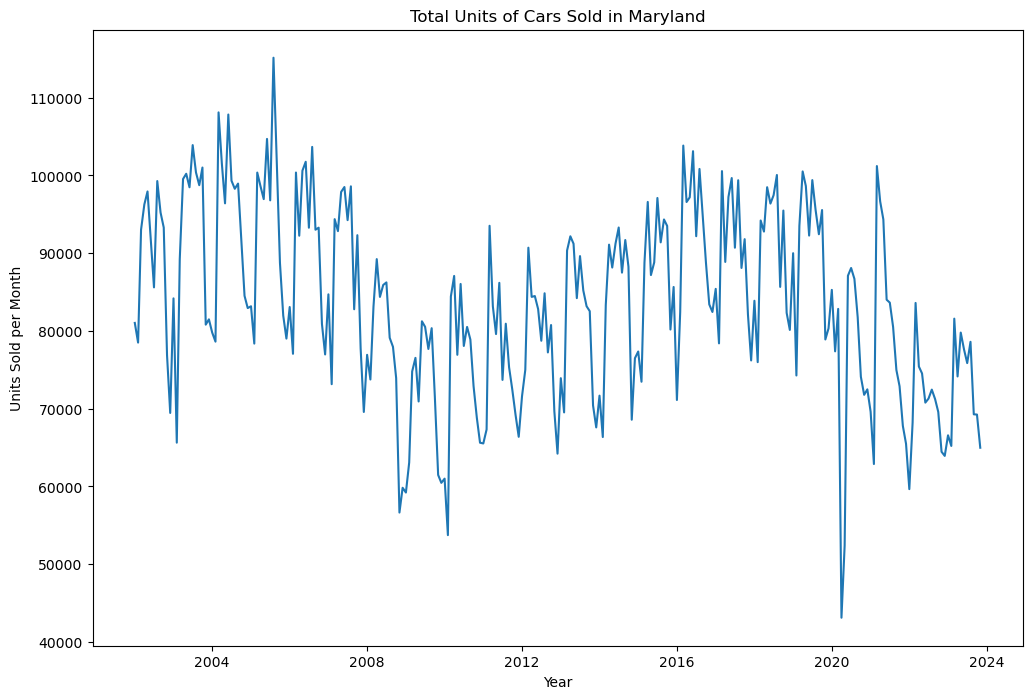

In [14]:
#Plot the total car sales data
line_series(monthly_sales['month'],monthly_sales['total_cars_sold'],'Total Units of Cars Sold in Maryland','Year',
            'Units Sold per Month')

Monthly Car Sales:
- Trend - Downwards
- Cycle - Two maximum points with proceeding minimums
- Seasonality - Recurring sharp decreases
- Irregularity - Large drop in 2020

##### Determine Seasonal Period
The most important step in understanding the data is looking at the seasonal patterns. By understanding how data changes within a year from month to month is crucial. There are two key ways to determine the period length of the seasonal variations.

1. Zoom into a smaller period to observe season values
2. Look at ACF to observe moving average

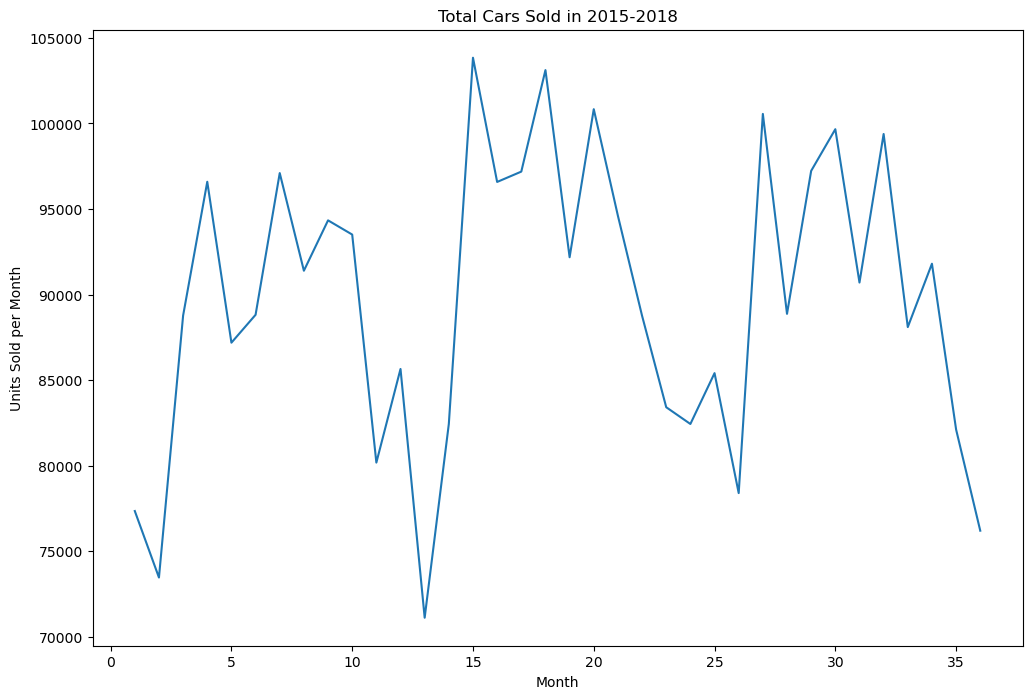

In [15]:
#Look at years 2015-2018 as this is not during a period of obscure movements in the overall data

#Create series of these values and then plot them
time_period_2015 = data_period(monthly_sales,monthly_sales['month'],monthly_sales['total_cars_sold'],'2015-01-01','2018-01-01')
line_series(range(1,len(time_period_2015)+1),time_period_2015.values,'Total Cars Sold in 2015-2018','Month','Units Sold per Month')

Visualising a few years will help identify patterns, this is observed above. It is likely that there is a yearly seasonal pattern as the middle months seem to show higher values compared to the drops that take place every 12 months. To confirm this, observe the ACF plot.

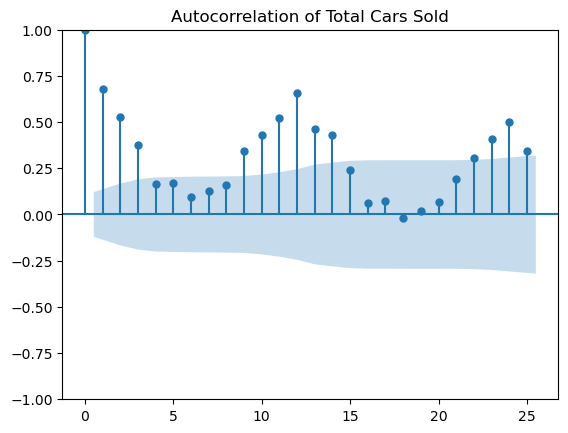

In [16]:
#ACF plot for monthly car sales
acf_monthly_car_sales = plot_acf(monthly_sales['total_cars_sold'],title='Autocorrelation of Total Cars Sold')

The ACF plot show a clear moving average where the lags at increments of k = 12 show a high correlation. This suggests that there is a seasonal period of 12, which would mean a year.

##### Define Seasonal Values as Parameters
Assume that there is a seasonality factor that repeats seasonal trends through 12 months or a cycle that goes for one year. Using statsmodels package create an automatic decomposition of the data.

In [17]:
#Create variables for different components that make up monthly car sales
trend_monthly_car_sales = additive_seasonal_decomposition(monthly_sales['total_cars_sold'],12)[0]
seasonality_monthly_car_sales = additive_seasonal_decomposition(monthly_sales['total_cars_sold'],12)[1]
residual_monthly_car_sales = additive_seasonal_decomposition(monthly_sales['total_cars_sold'],12)[2]

##### Plot Seasonal Decomposition

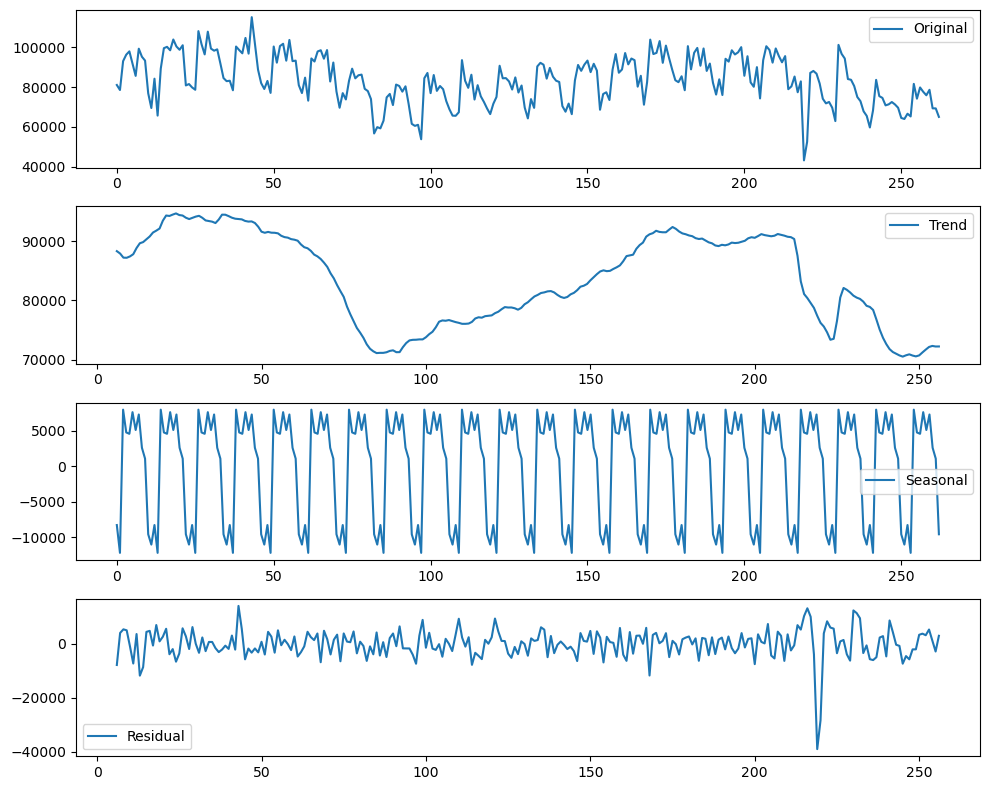

In [18]:
#Plot the total cars sold data seasonal decomposition
plot_additive_seasonal_decomposition(monthly_sales['total_cars_sold'],12)

- Trend: Displays both an overall trend and a cycle that exists in the data
- Seasonality: There is a seasonal period which repeats on a constant basis
- Residual: There seems to be no clear patterns for most of the data which suggests an accurate seasonality decomposition

#### Trend Analysis
There seems to be an overall downard trend in the movement of data values. Look at the least square lines on top of the original data to see how it moves.

##### Trend of Original Data
Looking at the original data and taking a least squares line to understand the overall movement of the data from 2002-2023.

In [19]:
#Create an incrementing month column, where each column after the date increases the value by 1
monthly_sales['incrementing_month'] = range(1,len(monthly_sales)+1)

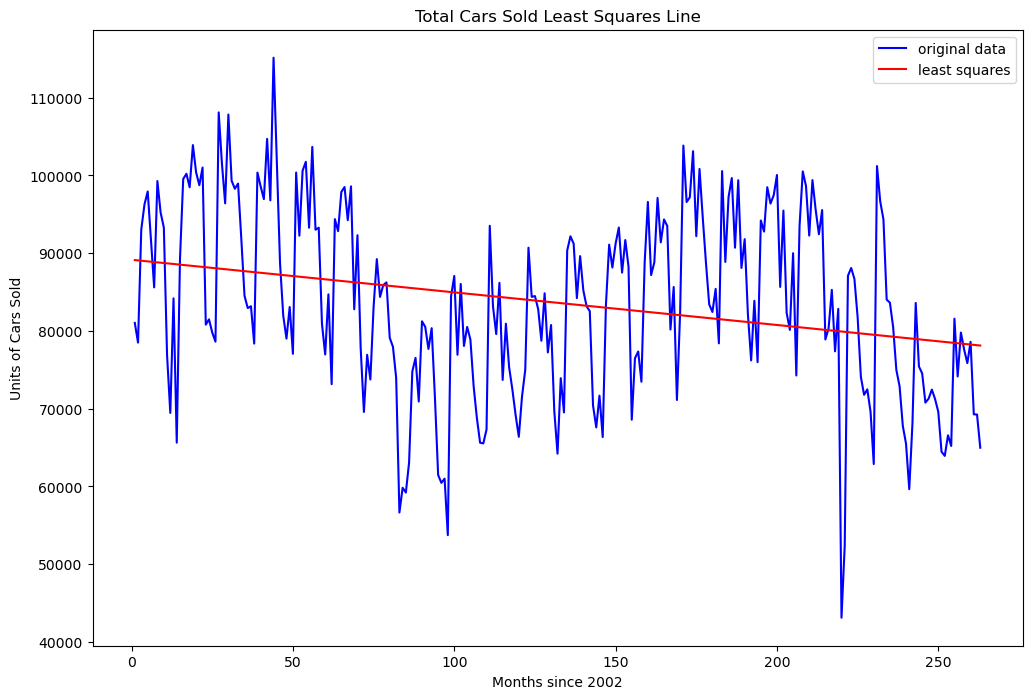

(-41.945386732386424, 89155.63135285751)

In [20]:
#Plot the least squares line for total cars sold
regression_original_car_sales = least_squares_line(monthly_sales['incrementing_month'],
                                                   monthly_sales['total_cars_sold'],
                                                   'Total Cars Sold Least Squares Line','Months since 2002','Units of Cars Sold')
regression_original_car_sales

The unit cars sold per month is decreasing by about 42 cars a month with a starting value of 89,156 cars. However, it looks as though that the noise is impacting the overall trend. The next step is to create data which takes a yearly average of the data (past 12 months) and to look at how data decreases over time. To make sure that the change in values is understood.

### Seasonality Analysis
The seasonality values within a period can be explored by looking at the average values per month within the cycle (12).

##### Seasonal Values without Anomalies
By using standard deviations, the values which most impact the variability of the monthly average values are going to be removed in an attempt to make forecasting more general and not specific to the individual changes that take place in this environment (including GFC and Covid-19).

In [21]:
#Create a list of the months of the year
months_of_year = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

#Convert the data to a dataframe which has each months data and values
monthly_sales_month_data = create_monthly_data(monthly_sales,'total_cars_sold','incrementing_month')
monthly_sales_month_data

,January,February,March,April,May,June,July,August,September,October,November,December
0,81033,78502,93019,96269,97936,91763,85602,99275,95225,93296,76878,69455
1,84188,65633,89218,99538,100214,98477,103899,100385,98743,101014,80810,81491
2,79788,78622,108106,101537,96408,107831,99323,98281,98950,91885,84513,82941
3,83171,78373,100365,98586,96956,104695,96794,115136,101850,88759,81968,79016
4,83076,77060,100372,92247,100611,101757,93273,103667,93018,93279,80914,76976
5,84707,73153,94375,92833,97875,98508,94250,98596,82789,92313,77753,69581
6,76929,73756,83096,89237,84374,85912,86243,79121,77957,73943,56645,59831
7,59217,63087,74792,76536,70930,81241,80529,77683,80353,71500,61485,60464
8,61007,53741,84430,87073,76931,86042,78070,80517,78891,72914,68826,65625
9,65531,67327,93524,83166,79599,86187,73703,80930,75334,72493,69217,66386


In [22]:
#Find the mean values of each month
#This will be used in the function below
mean_values = monthly_sales_month_data.mean()

#This function is going to find the zscores 
#Replace the zscores that are greater than 1 with the mean values as found above
#This is then going to create new values that can be used for monthly means
#The goal is reduce the impact of anomalies on data
monthly_sales_month_data_anomalies_removed = create_zscores(monthly_sales_month_data,1,mean_values)
monthly_sales_month_data_anomalies_removed

,January,February,March,April,May,June,July,August,September,October,November,December
0,81033,78502,93019,96269,97936,91763,85602,99275,95225,93296,76878,69455
1,84188,65633,89218,99538,100214,98477,88594.545455,100385,85800.818182,84267.227273,80810,72701.761905
2,79788,78622,91626.318182,88607.272727,96408,90928.818182,88594.545455,98281,85800.818182,91885,73801.818182,72701.761905
3,83171,78373,91626.318182,98586,96956,90928.818182,96794,90755.909091,85800.818182,88759,73801.818182,79016
4,83076,77060,91626.318182,92247,100611,90928.818182,93273,90755.909091,93018,93279,80914,76976
5,84707,73153,94375,92833,97875,98508,94250,98596,82789,92313,77753,69581
6,76929,73756,91626.318182,89237,84374,85912,86243,90755.909091,77957,73943,73801.818182,72701.761905
7,75669.636364,71744.863636,91626.318182,76536,88430.863636,90928.818182,80529,90755.909091,80353,84267.227273,73801.818182,72701.761905
8,75669.636364,71744.863636,84430,87073,76931,86042,88594.545455,80517,78891,84267.227273,68826,65625
9,75669.636364,67327,93524,83166,79599,86187,88594.545455,80930,85800.818182,84267.227273,69217,66386


This table represents all of the values in a manner which can be used to further decompose monthly average values. Find the mean and the z-score of each value to identify anomalies in the data.

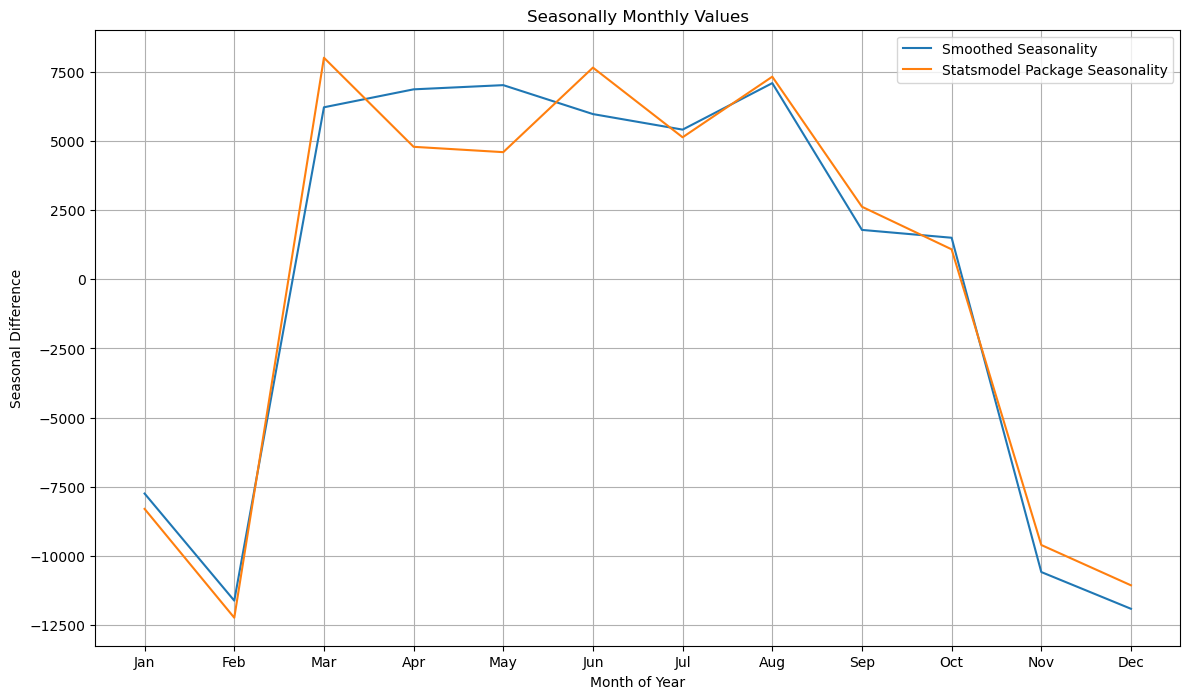

In [26]:
# Append the mean values as a new row
monthly_sales_month_data_anomalies_removed.loc['mean'] = monthly_sales_month_data_anomalies_removed.mean()

#Normalise the differences of the mean values
mean_of_means = (monthly_sales_month_data_anomalies_removed.loc['mean'].sum())/12

#Append the normalised the monthly mean values
monthly_sales_month_data_anomalies_removed.loc['normalised_mean'] = monthly_sales_month_data_anomalies_removed.loc['mean']-mean_of_means

#Plot the graph to see how it compares with the original monthly mean
plot_multiple_series(months_of_year,[monthly_sales_month_data_anomalies_removed.loc['normalised_mean'],seasonality_monthly_car_sales[0:12]],['Smoothed Seasonality','Statsmodel Package Seasonality'],'Seasonally Monthly Values','Month of Year','Seasonal Difference')

Observe that the data which had anomalies removed show that there is a general higher value of around 6000 cars greater than the average number of cars from Marc to September before decreasing to a low in December, January and February

#### Cyclical Analysis
Understanding how the cycle of movement in the data is likely the most important component as it will give the most information on how data will move during a certain time period. It is important to remove trend, seasonal components and major irregularities before continuing with the cyclical understanding. 

1. Create a list of continuing seasonal values
2. Remove Covid-19 Data
3. Deseasonalise Data
4. Smooth Data
5. Detrend Data

##### 1. Create list of Seasonal Values

In [37]:
#Create a seasonality series of the new values
seasonality_monthly_car_sales_smoothed = np.array(monthly_sales_month_data_anomalies_removed.loc['normalised_mean'])

#This will repeat the first function 22 times over to create a series length of 22 years which is how long the data last for (263)
seasonality_series = (np.tile(seasonality_monthly_car_sales_smoothed,22))[0:-1]

##### 2. Remove Covid-19 Data

In [25]:
# Ensure the 'month' column is in datetime format
trend_monthly_car_sales_df['month'] = pd.to_datetime(trend_monthly_car_sales_df['month'])

# Find the indices corresponding to 2020 and 2021
index_2020 = trend_monthly_car_sales_df.index[trend_monthly_car_sales_df['month'] == '2020-01-01']
index_2021 = trend_monthly_car_sales_df.index[trend_monthly_car_sales_df['month'] == '2021-12-01']

# Extracting indices as integers
index_2020 = index_2020[0] if len(index_2020) > 0 else None
index_2021 = index_2021[0] if len(index_2021) > 0 else None

# Print indices to check
print(f"Index for January 2020: {index_2020}")
print(f"Index for December 2021: {index_2021}")

NameError: name 'trend_monthly_car_sales_df' is not defined

In [ ]:
#Create a copy of the total cars sold to manipulate
monthly_sales_covid_removed = monthly_sales['total_cars_sold'].copy()

#Calculate the difference in total cars sold between December 2021 and January 2020
linearity_2020_to_2021  = (monthly_sales['total_cars_sold'].iloc[index_2021] - monthly_sales['total_cars_sold'].iloc[index_2020]) /24

#Create the linear trend data
linear_trend = [monthly_sales['total_cars_sold'].iloc[index_2020] + i * linearity_2020_to_2021 for i in range(25)]

#Adjust for seasonality
linear_trend_seasonal = [linear_trend[i] + seasonality_monthly_car_sales_altered[i % 12] for i in range(25)]

#Replace the existing data with new data
monthly_sales_covid_removed.iloc[index_2020:index_2020+25] = linear_trend_seasonal

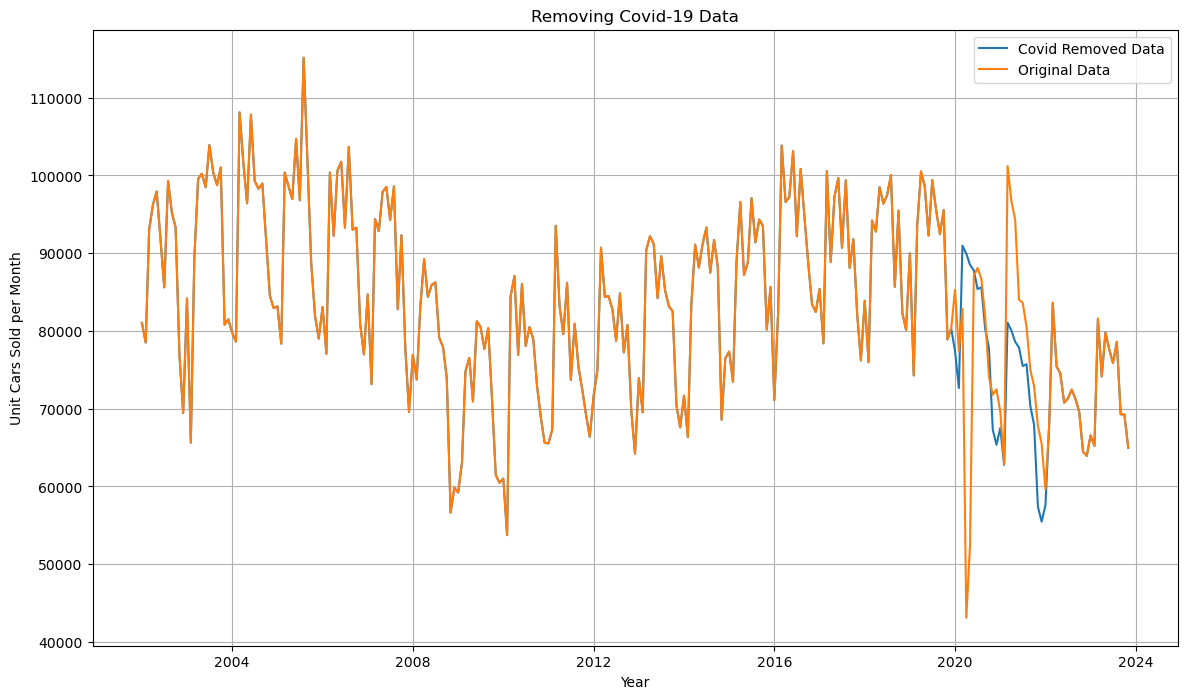

In [ ]:
#Create a plot of multiple lines
plot_multiple_series(monthly_sales['month'],[monthly_sales_covid_removed.values,monthly_sales['total_cars_sold']],
                     ['Covid Removed Data','Original Data'],'Removing Covid-19 Data','Year','Unit Cars Sold per Month')

##### 3. Deseasonalise Data

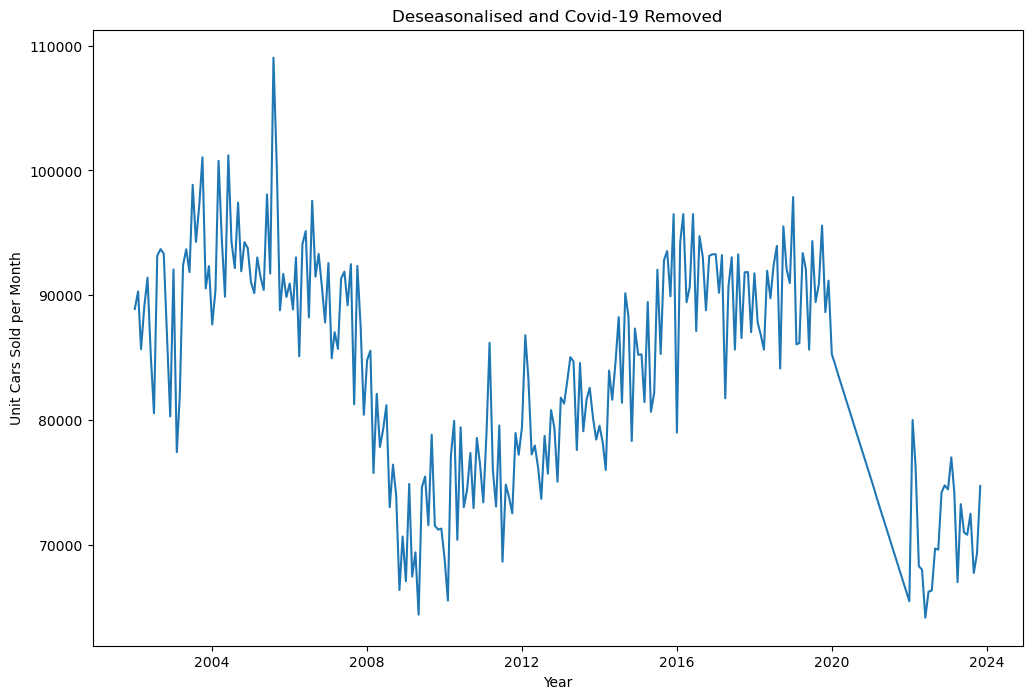

In [ ]:
#Create copy of series to keep just covid removed from original data
monthly_sales_covid_seasonal_removed = monthly_sales_covid_removed.copy()

#Remove trend of 38 cars sold per month
monthly_sales_covid_seasonal_removed -= seasonality_monthly_car_sales_altered

line_series(monthly_sales['month'],monthly_sales_covid_seasonal_removed.values,'Deseasonalised and Covid-19 Removed','Year','Unit Cars Sold per Month')

##### 4. Smooth Data

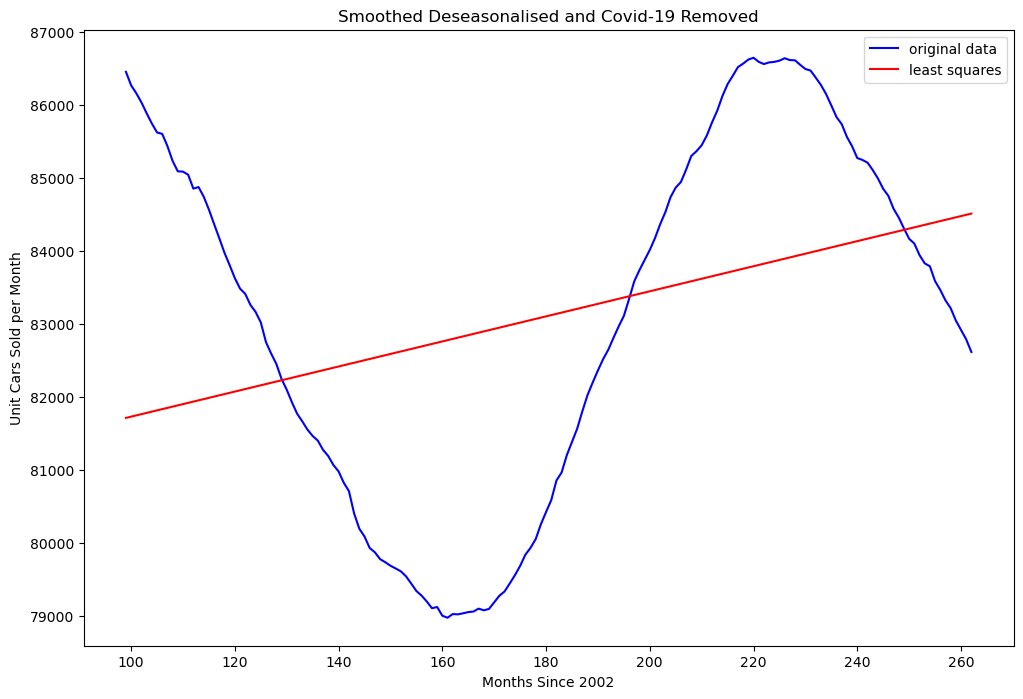

(17.156034846668675, 80015.07764213397)

In [ ]:
#Create a copy of series with covid and seasonal removed
monthly_sales_covid_seasonal_removed_smoothed = monthly_sales_covid_seasonal_removed.copy()

#Smooth the data by adding up the previous 35 values and find the average
monthly_sales_covid_seasonal_removed_smoothed = monthly_sales_covid_seasonal_removed_smoothed.rolling().mean()

#Plot the graph
least_squares_line(monthly_sales_covid_seasonal_removed_smoothed.dropna().index,monthly_sales_covid_seasonal_removed_smoothed.dropna().values,'Smoothed Deseasonalised and Covid-19 Removed','Months Since 2002','Unit Cars Sold per Month')

This trend matches up with the trend that was found in the original data, so removing the 42 cars sold per month for each month is likely going to identify the cycles that take place in the data.

##### 5. Detrend Data

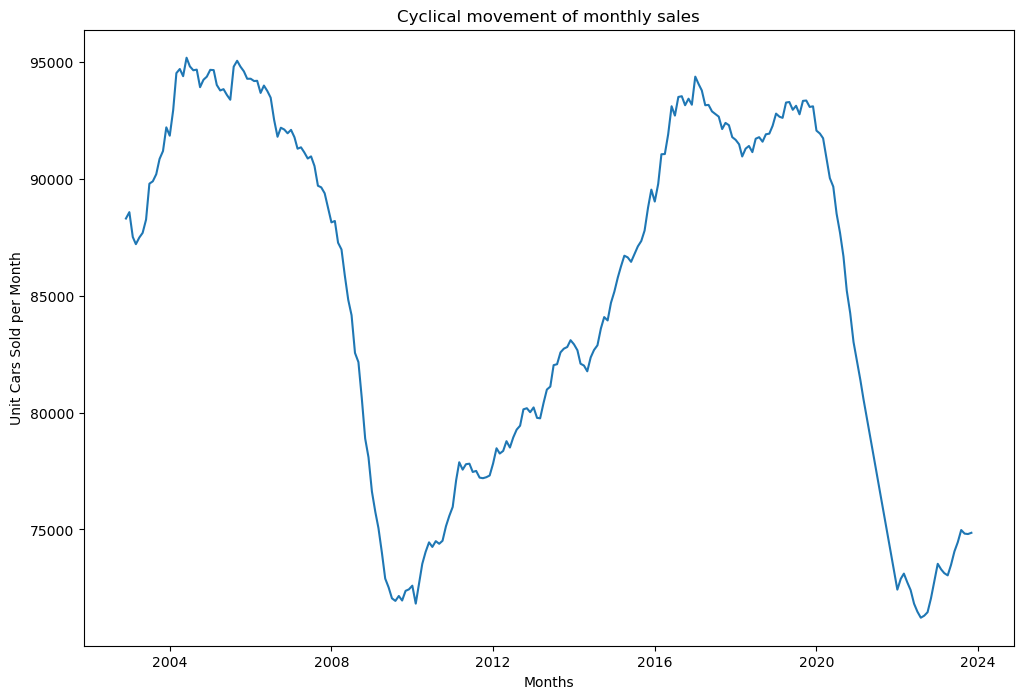

In [ ]:
#Create a copy of the data
monthly_sales_covid_seasonal_trend_removed_smoothed = monthly_sales_covid_seasonal_removed_smoothed.copy()

#Take away the trend value which was found above
monthly_sales_covid_seasonal_trend_removed_smoothed -= -10*(monthly_sales_covid_seasonal_removed_smoothed.index.dropna())

#Plot the data
line_series(monthly_sales['month'],monthly_sales_covid_seasonal_trend_removed_smoothed.values,'Cyclical movement of monthly sales','Months','Unit Cars Sold per Month')

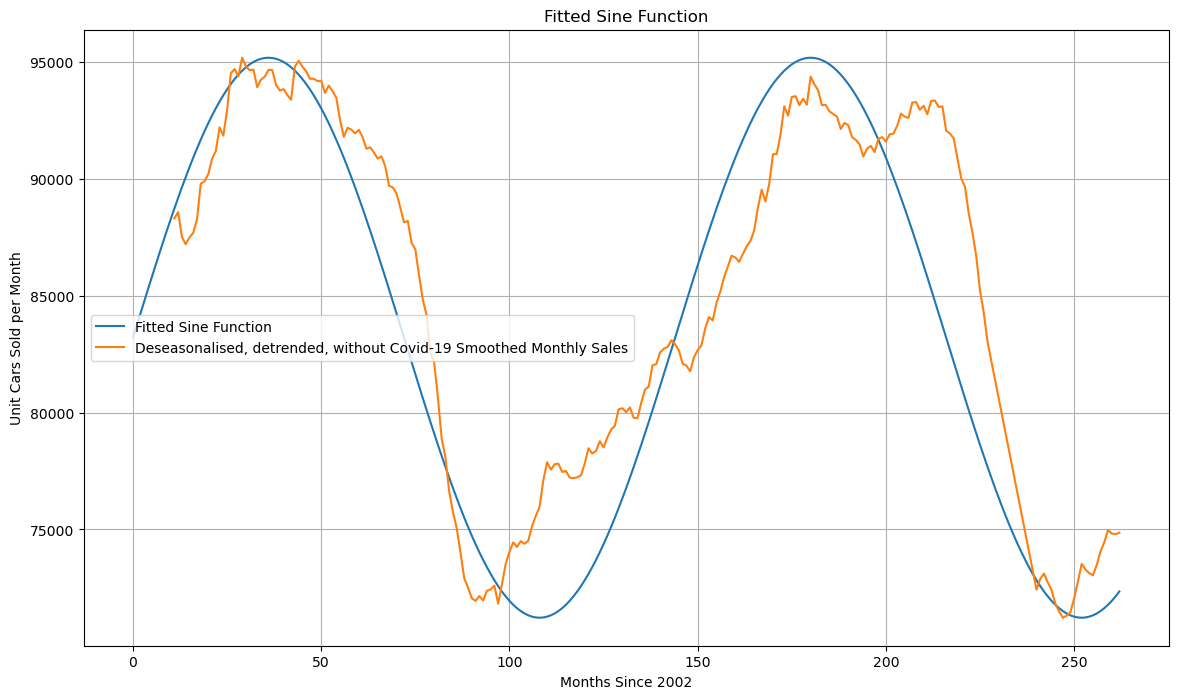

In [ ]:
# Calculated parameters
A = (monthly_sales_covid_seasonal_trend_removed_smoothed.max() - monthly_sales_covid_seasonal_trend_removed_smoothed.min())/2
D = (monthly_sales_covid_seasonal_trend_removed_smoothed.max() + monthly_sales_covid_seasonal_trend_removed_smoothed.min())/2
T = 144 #Visually inspection to find the time between two maximum periods
C = 0
B = 2 * np.pi / T

# X values
x_values = np.arange(0,263)
x_values_forecast = np.arange(0,324)

# Sine function
def sine_function(x, A, B, C, D):
    return A * np.sin(B * (x - C)) + D

# Calculate y values
y_values = sine_function(x_values, A, B, C, D)
y_values_forecast = sine_function(x_values_forecast, A, B, C, D)

#Plot the sine graph vs graph with adjustements (detrended, deseasonilised, anomalies removed and smoothed)
plot_multiple_series(x_values,[y_values,monthly_sales_covid_seasonal_trend_removed_smoothed],['Fitted Sine Function','Deseasonalised, detrended, without Covid-19 Smoothed Monthly Sales'],'Fitted Sine Function','Months Since 2002','Unit Cars Sold per Month')

### Model Evaluation
It is now time to add each component up for forecasting
- Trend: 42 Cars Sold per Month Decrease
- Cyclical: 11505.54 * sin(0.0436(x-6)) + 83815.625
- Seasonality: Adjusted Monthly Mean's
- Irregularities: Covid-19 Removed

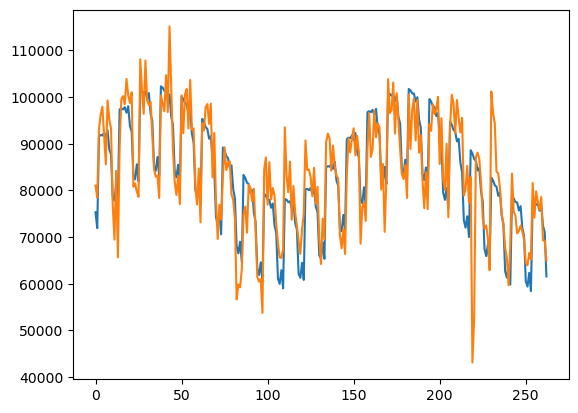

In [ ]:
#Prediction dataframe
forecast_monthly_sales = pd.DataFrame({'month':monthly_sales['month'],'incremenitng_month':monthly_sales['incrementing_month'],'monthly_sales':monthly_sales['total_cars_sold']})
forecast_monthly_sales['values'] = y_values - (4*monthly_sales['incrementing_month']) + seasonality_monthly_car_sales_altered

plt.plot(forecast_monthly_sales['values'])
plt.plot(monthly_sales['total_cars_sold'])

In [ ]:
residual =forecast_monthly_sales['values']-monthly_sales['total_cars_sold']
adfuller(residual)

(-3.5673963829763435,
 0.006415817181494701,
 14,
 248,
 {'1%': -3.4569962781990573,
  '5%': -2.8732659015936024,
  '10%': -2.573018897632674},
 4940.089954635223)

In [ ]:
mean_absolute_error(forecast_monthly_sales['values'],monthly_sales['total_cars_sold'])

4506.174698034941

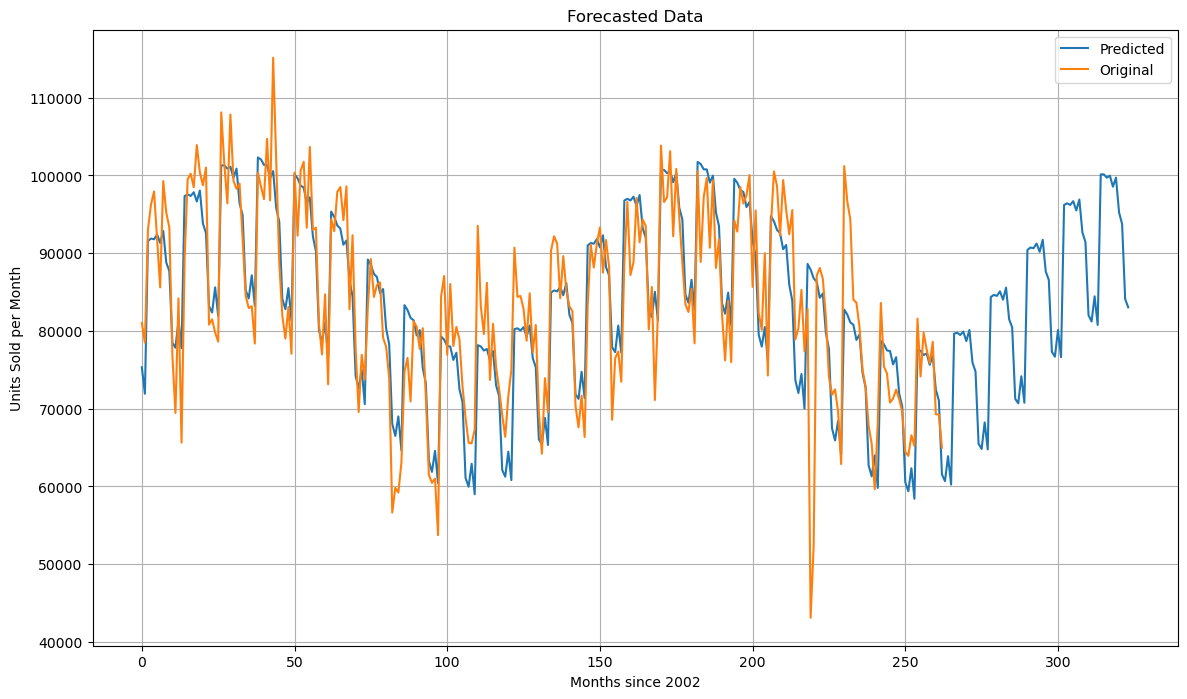

In [ ]:
plot_multiple_series_xvalues([x_values_forecast,x_values],[(y_values_forecast-(4*x_values_forecast) + seasonality_monthly_car_sales_altered_forecast),monthly_sales['total_cars_sold']],['Predicted','Original'],'Forecasted Data','Months since 2002','Units Sold per Month')

### Forecasting